In [1]:
from cell_mrcnn.data import get_channel_paths
from os.path import join, split, isdir, dirname
from os import mkdir
from glob import glob
from cell_mrcnn.utils import get_well_and_pos, calc_layers, convert_to_bit8, get_data_path_from_config_file,\
get_weights_path_from_config_file, get_results_path_from_config_file
from skimage.io import imread
import tensorflow as tf
from cell_mrcnn import cell
import pandas as pd
import numpy as np
import cell_mrcnn.model as modellib
from PIL import Image
from datetime import datetime
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [19]:
data_path = get_data_path_from_config_file()
MODEL_DIR = join(get_weights_path_from_config_file(), "logs")
config = cell.CellInferenceConfig()

In [20]:
active_folder = '20201112'

In [21]:
dataset_dir = join(data_path, active_folder, 'composite')
with open(join(data_path, active_folder, 'experiment_path.path'), 'r') as f:
    data_dir = f.read()

In [22]:
# data_dir = join(data_path, '20201112-CB2-1wt-2Q63R-3L133i-4Cer L10/2020-11-12/1340_cellm/TimePoint_1')
# dataset_dir = join(data_path, '20201112-CB2-1wt-2Q63R-3L133i-4Cer L10/2020-11-12/1340_cellm/composite')

In [23]:
wells = ['A01', 'A02', 'A03', 'B01', 'B02', 'B03']

# get the CB2 (w2) channel paths for each well
w2_paths = get_channel_paths(data_dir,'w2', wells)
w2_path_dict = {}
# get the composite image paths for mask prediction  
composite_image_paths = glob(join(dataset_dir, '*.png'))
mask_path_dict = {}
# initialise other dicts
result_dict = {}
df_dict = {}
for well in wells:
    w2_path_dict[well] = {}
    mask_path_dict[well] = {}
    result_dict[well] = {}
    df_dict[well] = pd.DataFrame()
    
for path in w2_paths:
    well, pos = get_well_and_pos(path)
    w2_path_dict[well][pos] = path

for path in composite_image_paths:
    tail = split(path)[1].split('.')[0]
    well, pos = tail.split('s')
    mask_path_dict[well][pos] = path

In [39]:
config.DETECTION_MIN_CONFIDENCE = 0.9
DEVICE = "/cpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                      config=config)
    weights_path = join(get_weights_path_from_config_file(), "mask_rcnn_cell_0027.h5")
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)

Loading weights  /workspace/projects/cell_mrcnn/logs/mask_rcnn_cell_0027.h5


In [41]:
for i, well in enumerate(wells):
    for j,(pos, path) in enumerate(w2_path_dict[well].items()):
        print('\r{}/{} well: {}/{} position...'.format(i+1, len(wells), j+1, len(w2_path_dict[well].items())), end='')
        layers_image = imread(path)
        mask_image = imread(mask_path_dict[well][pos])
        
        mask_image = mask_image[:,:,(0,2)]
            
        results = model.detect([mask_image], verbose=0)[0]
        result_dict[well][pos] = results
        layers = calc_layers(layers_image, results['masks'])
        df = pd.DataFrame(layers)
        df_dict[well] = pd.concat([df_dict[well], df], axis=0, ignore_index = True)
    df_dict[well].loc['mean',:] = df_dict[well].mean(axis=0)

6/6 well: 25/25 position...

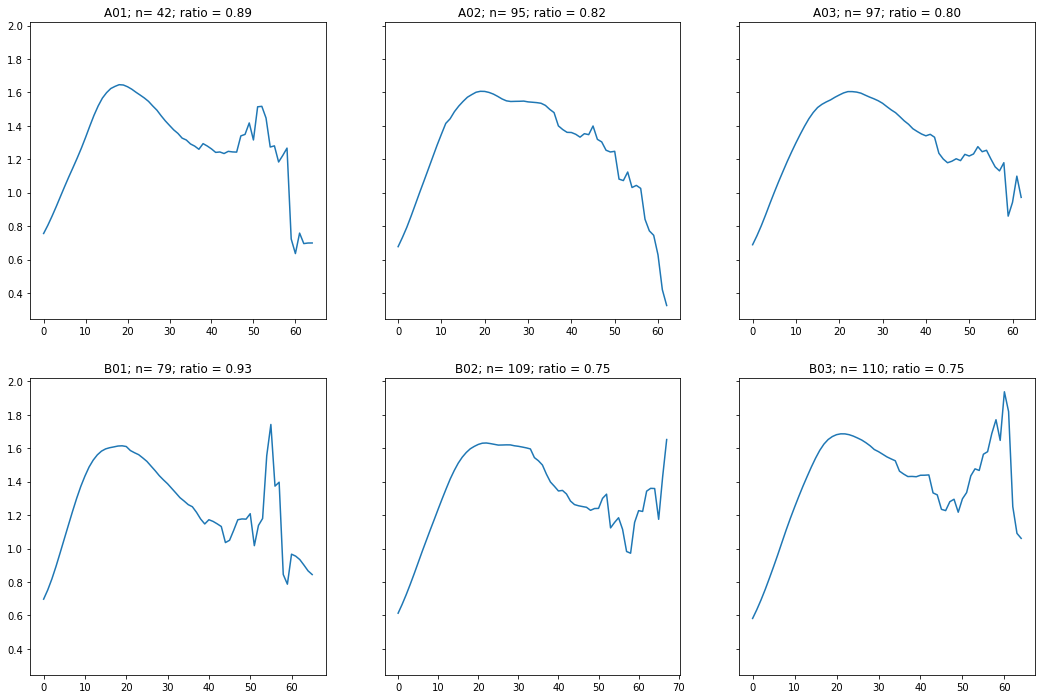

In [42]:
rows=2; cols=3; size = 6
fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows), sharey = True)
row, col = 0, 0
for j, well in enumerate(wells):
    ax[row, col].plot(np.arange(len(df_dict[well].loc['mean',:])), df_dict[well].loc['mean',:])
    ratio = df_dict[well].loc['mean',:][:20].sum() / df_dict[well].loc['mean',:][20:40].sum()
    ax[row, col].set_title(f"{well}; n= {df_dict[well].shape[0]-1}; ratio = {ratio:.2f}")
    col += 1
    if (j+1) % 3 == 0:
        row += 1
        col = 0

In [10]:
# save the results
results_dir = get_results_path_from_config_file()
if not isdir(results_dir):
    mkdir(results_dir)
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
output_folder = join(results_dir, date)
if not isdir(output_folder):
    mkdir(output_folder)
for well in result_dict.keys():
    well_dir = join(output_folder, well)
    if not isdir(well_dir):
        mkdir(well_dir)
    with open(join(well_dir, 'results.csv'), 'w') as f:
        f.write(df_dict[well].to_csv())
    for pos, r in result_dict[well].items():
        for m in range(r['masks'].shape[2]):
            mask_ = Image.fromarray((r['masks'][:,:,m]*255).astype(np.uint8),
                                    mode = 'L')
            mask_ = mask_.convert(mode='1')
            mask_.save(join(well_dir, pos + '_mask_' + str(m) +
                       '.png'))